# Outlier analysis

Testing outlier removal

Methods: LOF, Z-score, Cook's Distance, DFFITS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd. read_csv('train_wells_20210131.csv')
#data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,230808.000000,230808.000000,230808.000000,230808.000000,230808.000000
mean,8359.543157,125.055371,68.332163,76.981640,2.576985
std,3932.169198,32.878708,15.225018,44.878094,0.179276
min,558.000000,40.615300,40.089000,0.731000,1.223200
25%,5430.000000,99.785675,55.592000,38.744975,2.497300
50%,8139.000000,115.758000,66.248850,78.584250,2.611900
75%,11445.000000,142.390400,78.852225,108.689000,2.679600
max,18740.000000,240.531000,166.269100,623.161700,3.105200


In [3]:
cols=['GAMMA','RHO','DTCO']

X, X_test, Y, Y_test = train_test_split(data[cols], data[['DTSM']], test_size=0.1, random_state=42)

k = X.shape[1]
N = X.shape[0]

##Local Outlier Factor (LOF)
A data points are identified as outlier if they have substantially lower density than their neighbors. 


In [4]:
lof = LocalOutlierFactor(n_neighbors=30, contamination=0.15)
mask_lof = lof.fit_predict(X)
mask_l = mask_lof == -1

out_num_l = sum(mask_l)
out_pc_l = 100 * out_num_l / N

print("outlier #:", out_num_l)
print("outlier %: {:.1f}%".format(out_pc_l))

outlier #: 31159
outlier %: 15.0%


In [5]:
Xl, Yl = X[mask_l], Y[mask_l]
Xl_out, Yl_out = X[~mask_l], Y[~mask_l]

print(X.shape, Y.shape)
print(Xl.shape, Yl.shape)
print(Xl_out.shape, Yl_out.shape)

(207727, 3) (207727, 1)
(31159, 3) (31159, 1)
(176568, 3) (176568, 1)


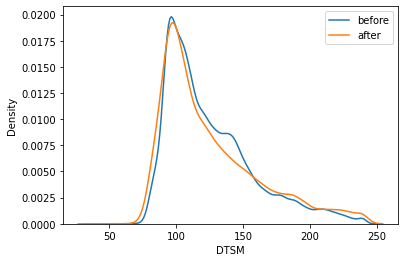

In [6]:
fig = sns.kdeplot(Y.DTSM, label = "before")
fig = sns.kdeplot(Yl.DTSM, label = "after")
plt.legend()

In [7]:
def cm_wh(cmp_name):
  cmp = cm.get_cmap(cmp_name, 256)
  newcm = cmp(np.linspace(0, 1, 256))
  newcm[0, :] = np.array([1, 1, 1, 1])
  return ListedColormap(newcm)


def plot_feat_hist(X, Y, fig, ax, title=''):

  ax1, ax2, ax3 = ax 

  h1 = ax1.hist2d(X.DTCO,Y.DTSM,bins=50, cmap=cm_wh('jet'))
  #ax1.scatter(X.DTCO, pred, s=1, color='blue', alpha=0.2)
  ax1.set_xlabel("Test DTCO")
  ax1.set_ylabel("DTSM")
  ax1.set_title(title, loc='left')
  ax1.set_xlim(40,170)
  ax1.set_ylim(40,250)
  ax1.grid()
  h1[3].set_clim(0,2000)
  fig.colorbar(h1[3], ax=ax1)
  
  h2 = ax2.hist2d(X.GAMMA,Y.DTSM,bins=50, cmap=cm_wh('jet'))
  #ax2.hist2d(X_test.GAMMA,pred,bins=50, cmap=cm_wh('jet'), alpha=0.3)
  #ax2.scatter(X_test.GAMMA, pred, s=1, color='blue', alpha=0.3)
  ax2.set_xlabel("Test GAMMA")
  ax2.set_ylabel("DTSM")
  ax2.set_xlim(0,650)
  ax2.set_ylim(40,250)
  ax2.grid()  
  h2[3].set_clim(0,3000)
  fig.colorbar(h2[3], ax=ax2)

  h3 = ax3.hist2d(X.RHO,Y.DTSM,bins=50, cmap=cm_wh('jet'))
  #ax3.scatter(X_test.RHO, pred, s=1, color='blue', alpha=0.3)
  ax3.set_xlabel("Test RHO")
  ax3.set_ylabel("DTSM")
  ax3.set_xlim(1,3.2)
  ax3.set_ylim(40,250)
  ax3.grid()
  h3[3].set_clim(0,2500)  
  fig.colorbar(h3[3], ax=ax3);

def plot_feat_sct(X, Y, fig, ax, title='', color='orange'):

  ax1, ax2, ax3 = ax 

  ax1.scatter(X.DTCO,Y.DTSM, s=1, color=color)
  ax1.set_xlabel("Test DTCO")
  ax1.set_ylabel("DTSM")
  ax1.set_title(title, loc='left')
  ax1.set_xlim(40,170)
  ax1.set_ylim(40,250)
  ax1.grid()
  
  ax2.scatter(X.GAMMA, Y.DTSM, s=1, color=color, alpha=0.3)
  ax2.set_xlabel("Test GAMMA")
  ax2.set_ylabel("DTSM")
  ax2.set_xlim(0,650)
  ax2.set_ylim(40,250)
  ax2.grid()  

  ax3.scatter(X.RHO, Y.DTSM, s=1, color=color, alpha=0.3)
  ax3.set_xlabel("Test RHO")
  ax3.set_ylabel("DTSM")
  ax3.set_xlim(1,3.2)
  ax3.set_ylim(40,250)
  ax3.grid()

def plot_resid_pred_sct(pred, obser, resid, fig, ax, title):

  ax1, ax2, ax3 = ax 
  ax1.scatter(pred, obser, s=1, color='blue', label='data')
  ax1.set_xlabel("Predicted")
  ax1.set_ylabel("Observe")
  #ax1.set_xlim(70,240)
  #ax1.set_ylim(70,240)
  #ax1.set_xticks(np.arange(80,240,20))
  #ax1.set_yticks(np.arange(80,240,20))
  ax1.grid()
  ax1.set_title(title, loc='left')

  ax2.scatter(pred, resid, s=1, color='blue', label='data')
  ax2.set_xlabel("Predicted")
  ax2.set_ylabel("Residual")
  #ax2.set_xlim(75,240)
  ax2.set_ylim(-150,150)
  ax2.grid()

  n, bins, patches = ax3.hist(resid.Resid_DTSM, np.arange(-80,85,5), density=False, facecolor='orange')
  #ax3.plot(bins, norm.pdf(bins, np.mean(resid), np.std(resid)), label='Gaussian')
  ax3.set_xlabel("Residual")
  ax3.set_ylabel("Frequency")
  ax3.set_xlim(-80,80)
  ax3.set_ylim(0,40000)
  #ax3.legend()
  ax3.grid()


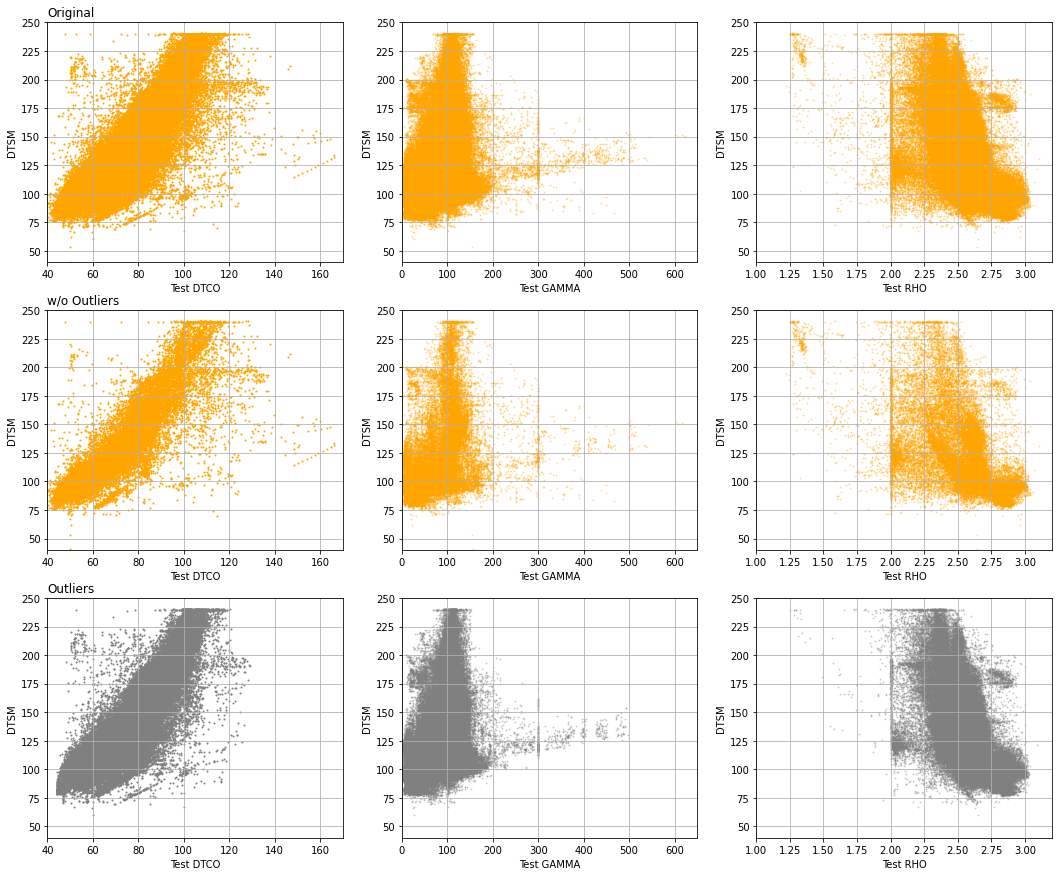

In [8]:
fig, ax = plt.subplots(3,3,figsize=(18,15))

plot_feat_sct(X, Y, fig, ax[0,:], 'Original', 'orange')
plot_feat_sct(Xl, Yl, fig, ax[1,:], 'w/o Outliers','orange')
plot_feat_sct(Xl_out, Yl_out, fig, ax[2,:], 'Outliers','gray')

##Identify outliers after regression

In [9]:
X_train = X.copy()
X_train['DTCO2'] = X_train.DTCO**2
X_test['DTCO2'] = X_test.DTCO**2

#scaler_x = preprocessing.StandardScaler().fit(X_train)
#_train_sc = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)

In [10]:
model = sm.OLS(Y,sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   DTSM   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 2.228e+05
Date:                Fri, 07 May 2021   Prob (F-statistic):               0.00
Time:                        21:57:08   Log-Likelihood:            -8.4745e+05
No. Observations:              207727   AIC:                         1.695e+06
Df Residuals:                  207722   BIC:                         1.695e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.6102      0.929     66.284      0.0

In [11]:
r2 = results.rsquared
print("R2: ", r2)

R2:  0.8109588787552237


In [12]:
pred = results.fittedvalues
obser = Y['DTSM']
resid = obser - pred

### Z-scores

This method discards data points whose standardized residual is large than a certain Z.

In [13]:
resid_std = np.std(resid)
z_scores = resid/resid_std
d_out = 3
mask_z = abs(z_scores) > d_out

out_num_z = sum(mask_z)
out_pc_z = 100 * out_num_z / N

print('resid std: ', resid_std)
print("outlier #:", out_num_z)
print("outlier %: {:.1f}%".format(out_pc_z))

resid std:  14.306299981159931
outlier #: 3147
outlier %: 1.5%


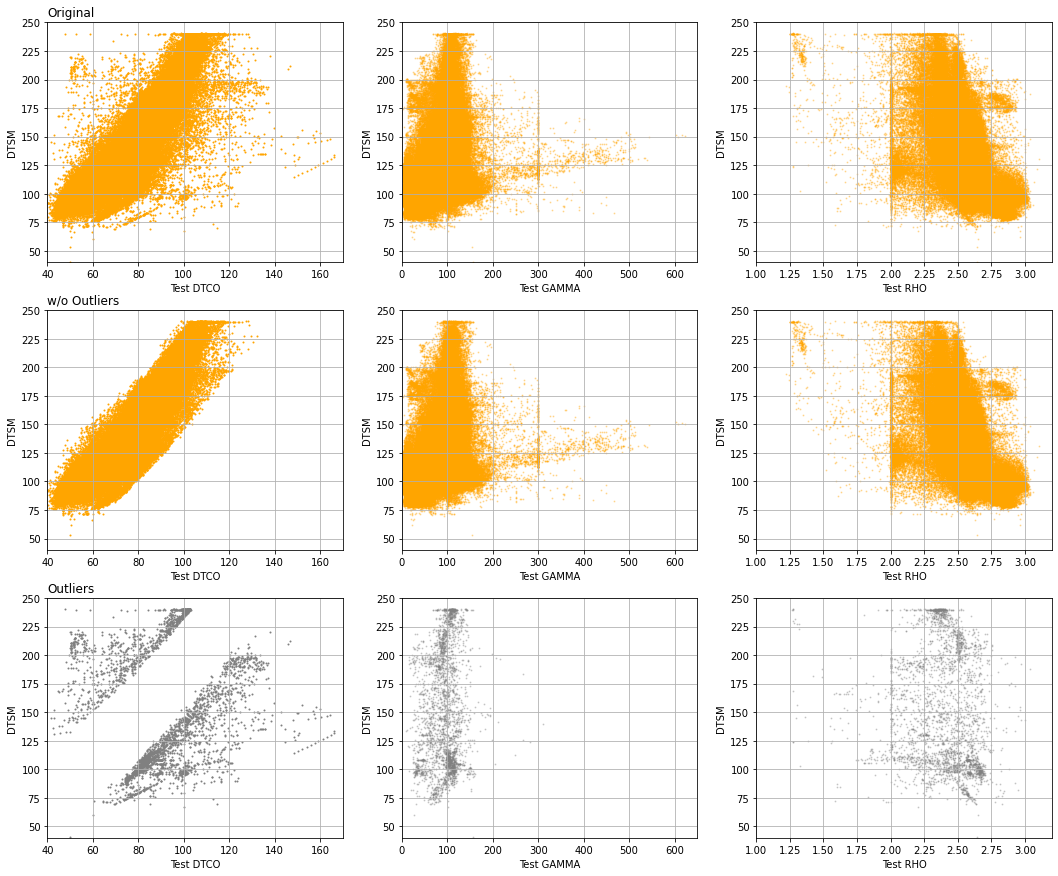

In [14]:
Xz, Yz = X[~mask_z], Y[~mask_z]
Xz_out, Yz_out = X[mask_z], Y[mask_z]

fig, ax = plt.subplots(3,3,figsize=(18,15))

plot_feat_sct(X, Y, fig, ax[0,:], 'Original', 'orange')
plot_feat_sct(Xz, Yz, fig, ax[1,:], 'w/o Outliers', 'orange')
plot_feat_sct(Xz_out, Yz_out, fig, ax[2,:], 'Outliers', 'gray')

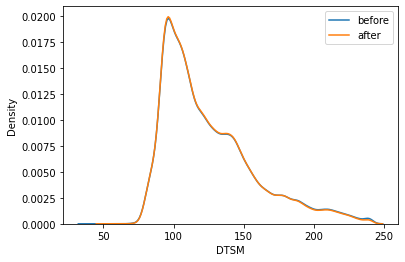

In [15]:
fig = sns.kdeplot(Y.DTSM, label = "before")
fig = sns.kdeplot(Yz.DTSM, label = "after")
plt.legend();

## Cook's distance

This method discards data points with large Cook’s distance, the influence of a single data point on coefficient estimates of the OLS regression.

In [17]:
influence = results.get_influence()
cooks_d = influence.cooks_distance[0]

In [18]:
cooks_d_threshold = 4 / N
mask_d = cooks_d > cooks_d_threshold

pred_dout = pred[mask_d]
resid_dout = resid[mask_d]
obser_dout = obser[mask_d]

pred_d = pred[~mask_d]
resid_d = resid[~mask_d]
obser_d = obser[~mask_d]

cd_size_out = (cooks_d[mask_d])*1000+5
cd_hist = np.minimum(cooks_d, 1e-4)

out_num_d = sum(mask_d)
out_pc_d = 100 * out_num_d / N


print("max cooks_d: ", max(cooks_d))
print("Cook's Distance Threshold: ", cooks_d_threshold)
print("outlier #:", out_num_d)
print("outlier %: {:.1f}%".format(out_pc_d))

max cooks_d:  0.24646209268781136
Cook's Distance Threshold:  1.9256042786927074e-05
outlier #: 15045
outlier %: 7.2%


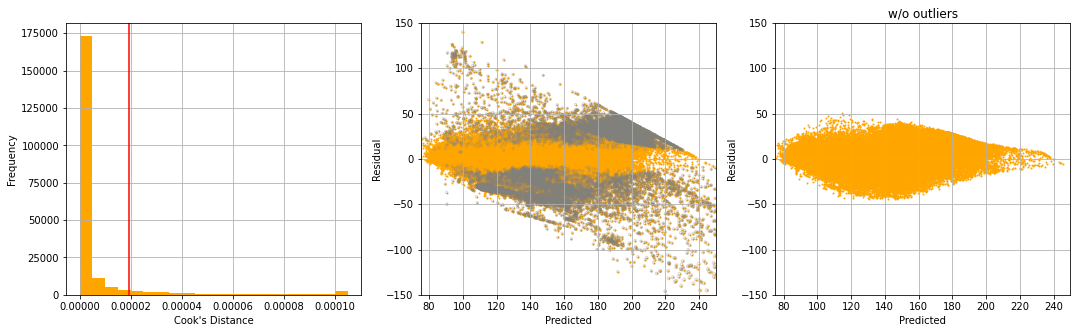

In [19]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax1, ax2, ax3 = ax 

n, bins, patches = ax1.hist(cd_hist, bins=np.arange(0.0,1.1e-4,0.5e-5) , density=False, facecolor='orange')
ax1.axvline(x = cooks_d_threshold, color = 'r', label = 'Threshold')
ax1.set_xlabel("Cook's Distance")
ax1.set_ylabel("Frequency")
#ax1.set_xlim(0,10)
#ax1.set_ylim(0,40000)
#ax1.legend()
ax1.grid()
  
ax2.scatter(pred, resid, s=1, color='orange')
ax2.scatter(pred_dout, resid_dout, s=cd_size_out, c='none', ec='gray', alpha=0.3)
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Residual")
ax2.set_xlim(75,250)
ax2.set_ylim(-150,150)
ax2.grid()  

ax3.scatter(pred_d, resid_d, s=1, color='orange')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Residual")
ax3.set_xlim(75,250)
ax3.set_ylim(-150,150)
ax3.set_title('w/o outliers')
ax3.grid()  

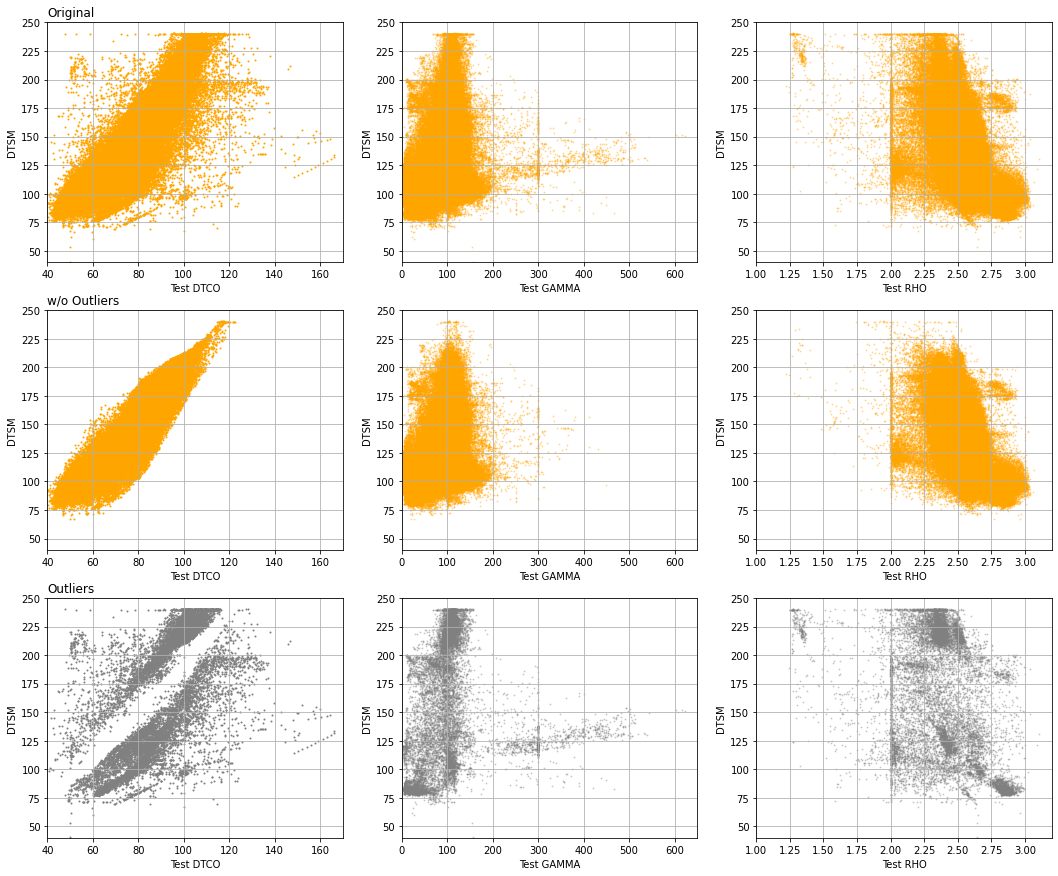

In [20]:
Xd, Yd = X[~mask_d], Y[~mask_d]
Xd_out, Yd_out = X[mask_d], Y[mask_d]

fig, ax = plt.subplots(3,3,figsize=(18,15))

plot_feat_sct(X, Y, fig, ax[0,:], 'Original', 'orange')
plot_feat_sct(Xd, Yd, fig, ax[1,:], 'w/o Outliers', 'orange')
plot_feat_sct(Xd_out, Yd_out, fig, ax[2,:], 'Outliers', 'gray')

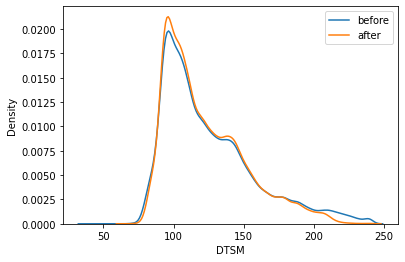

In [21]:
fig = sns.kdeplot(Y.DTSM, label = "before")
fig = sns.kdeplot(Yd.DTSM, label = "after")
plt.legend();

### DFFITS

This method discards data points out of DFFITS threshold, the influence of a single data point on predicted values from the regression.

In [23]:
dffits, dffits_threshold = influence.dffits_internal
mask_f = abs(dffits) > dffits_threshold

out_num_f = sum(mask_f)
out_pc_f = 100 * out_num_f / N

print("dffits range: ", min(dffits), '-', max(dffits))
print("dffits threshold: ", dffits_threshold)
print("outlier #:", out_num_f)
print("outlier %: {:.1f}%".format(out_pc_f))

dffits range:  -1.1100947993027697 - 0.07506168228891494
dffits threshold:  0.009812248159042624
outlier #: 15045
outlier %: 7.2%


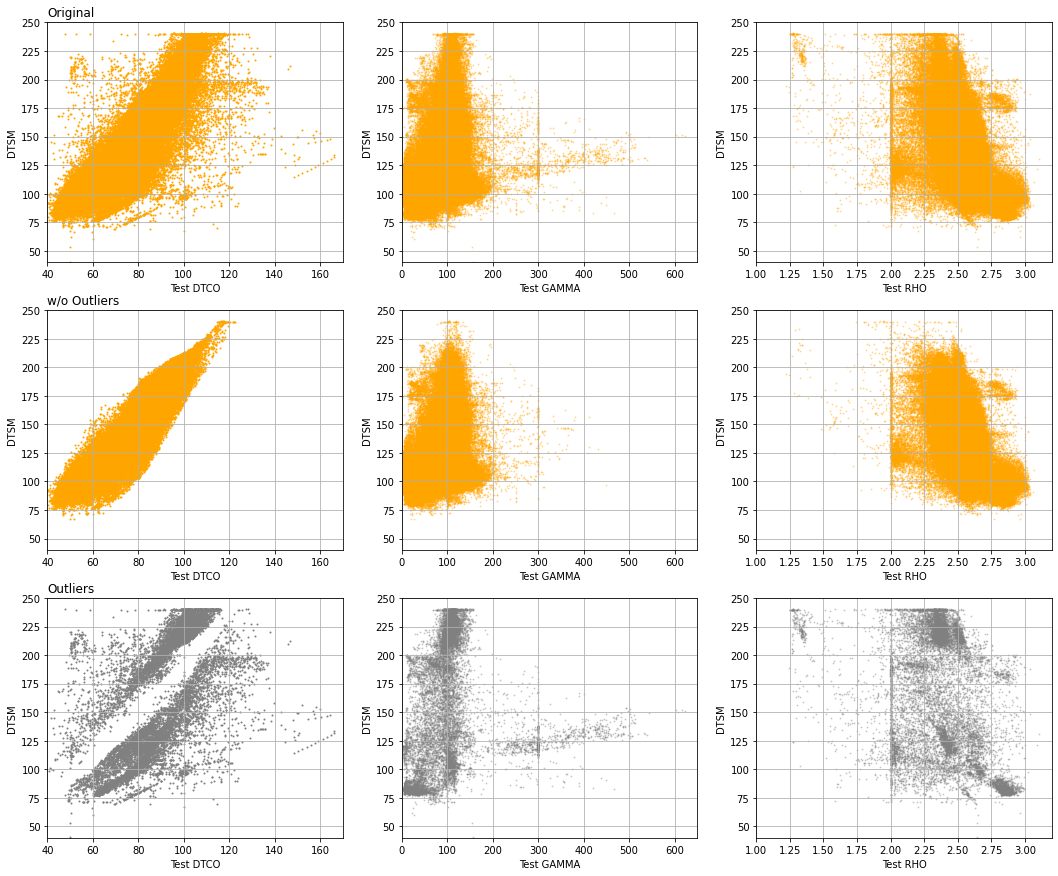

In [24]:
Xf, Yf = X[~mask_f], Y[~mask_f]
Xf_out, Yf_out = X[mask_f], Y[mask_f]

fig, ax = plt.subplots(3,3,figsize=(18,15))

plot_feat_sct(X, Y, fig, ax[0,:], 'Original', 'orange')
plot_feat_sct(Xf, Yf, fig, ax[1,:], 'w/o Outliers', 'orange')
plot_feat_sct(Xf_out, Yf_out, fig, ax[2,:], 'Outliers', 'gray')

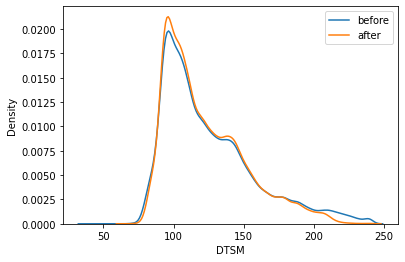

In [25]:
fig = sns.kdeplot(Y.DTSM, label = "before")
fig = sns.kdeplot(Yf.DTSM, label = "after")
plt.legend();

## Regression w/o outliers

In [26]:
results_l = sm.OLS(Y[~mask_l],sm.add_constant(X_train[~mask_l])).fit()
r2_l = results_l.rsquared

results_z = sm.OLS(Y[~mask_z],sm.add_constant(X_train[~mask_z])).fit()
r2_z = results_z.rsquared

results_d = sm.OLS(Y[~mask_d],sm.add_constant(X_train[~mask_d])).fit()
r2_d = results_d.rsquared

results_f = sm.OLS(Y[~mask_f],sm.add_constant(X_train[~mask_f])).fit()
r2_f = results_f.rsquared

In [27]:
pred_lt = results_l.predict(sm.add_constant(X_test))
r2_lt = r2_score(Y_test, pred_lt)

pred_zt = results_z.predict(sm.add_constant(X_test))
r2_zt = r2_score(Y_test, pred_zt)

pred_dt = results_d.predict(sm.add_constant(X_test))
r2_dt = r2_score(Y_test, pred_dt)

pred_ft = results_f.predict(sm.add_constant(X_test))
r2_ft = r2_score(Y_test, pred_ft)

pred_0t = results.predict(sm.add_constant(X_test))
r2_0t = r2_score(Y_test, pred_0t)


R2 of old model without outliers is for fair comparison with the new model.


In [28]:
titles = ['Original','LOF', 'Z-score', "Cook's D", ' DFFITS']
out_num = [0, out_num_l, out_num_z, out_num_d, out_num_f]
out_pc = [0, out_pc_l, out_pc_z, out_pc_d, out_pc_f]
r2_s = [r2, r2_l, r2_z, r2_d, r2_f]
r2_st = [r2_0t, r2_lt, r2_zt, r2_dt, r2_ft]

reg_results = pd.DataFrame({'Method': titles,
                            'Outlier #': out_num,
                            'Outlier %': out_pc,
                            'R2 (train)': r2_s,
                            'R2 (test)': r2_st})

reg_results

,Method,Outlier #,Outlier %,R2 (train),R2 (test)
0,Original,0,0.000000,0.810959,0.806184
1,LOF,31159,14.999976,0.835458,0.797387
2,Z-score,3147,1.514969,0.880153,0.791978
3,Cook's D,15045,7.242679,0.899311,0.793983
4,DFFITS,15045,7.242679,0.899311,0.793983


##Clean up full dataset

Apply Cooks distance method to exclude outliers on full dataset

In [32]:
results_2 = sm.OLS(data[['DTSM']],sm.add_constant(data[cols])).fit()
cooks_d2 = results_2.get_influence().cooks_distance[0]
mask_d2 = cooks_d2 > cooks_d_threshold

data_ps = data[~mask_d2]
results_2c = sm.OLS(data_ps[['DTSM']],sm.add_constant(data_ps[cols])).fit()

In [33]:
print("old model R2: ",results_2.rsquared)
print("new model R2: ",results_2c.rsquared)

data_ps.to_csv('train_wells_20210131_ps1.csv', index=False)

old model R2:  0.8071477394169891
new model R2:  0.8853364804087325


## Reference

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

https://medium.com/mlpoint/local-outlier-factor-a-way-to-detect-outliers-dde335d77e1a

https://igorpavlovsky.com/detection-of-outliers-in-ml-datasets/

https://towardsdatascience.com/a-short-journey-of-outlier-detection-bdf143464a92